### Author: [Parvaneh Yaghoubi](https://github.com/parvanehyaghoubi)

# Muscle artefacts removal (component decomposition)

## Import libraries

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.interpolate as spi
from scipy import signal
from sklearn.decomposition import PCA,FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from pyts.decomposition import SingularSpectrumAnalysis

from PyEMD import EEMD

## Import Dataset

In [3]:
data = pd.read_excel("dataset/dataset.xlsx")
display(data.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3


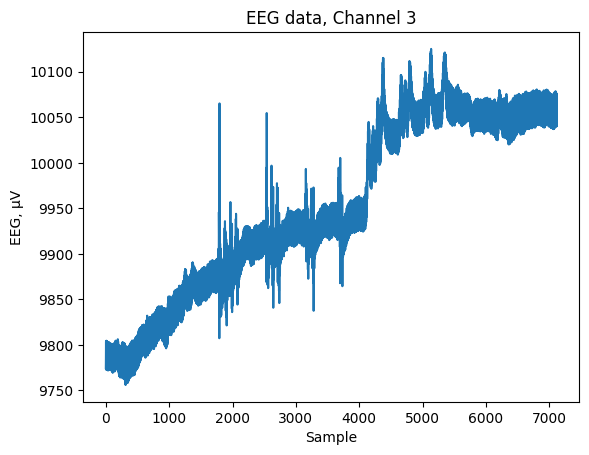

In [4]:
# select the data from the third channel
channel = 2
channel_data = data.iloc[:, channel]
channel_data = round(1000000*4.5*(channel_data/16777215),2)  # Convert data from ADC to µV

# plot the EEG data
plt.plot(channel_data)
plt.title("EEG data, Channel " + str(channel+1))
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

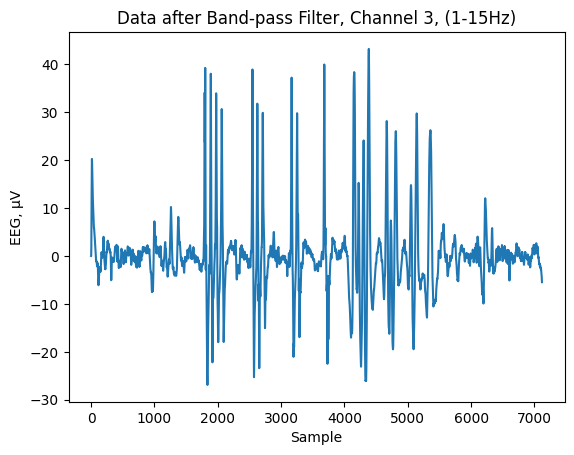

In [5]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 15  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Data after Band-pass Filter, Channel " +  str(channel+1) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

In [6]:
# apply the band-pass filter for the whole dataset
data_bp_filtered = data.copy()  # copy the data

for ch in range(data_bp_filtered.shape[1]):
    data_bp_filtered.iloc[:, ch] = butter_highpass_filter(
        data=data_bp_filtered.iloc[:, ch],
        cutoff=cutoff_high,
        nyq=nyq,
        order=5)
    data_bp_filtered.iloc[:, ch] = butter_lowpass_filter(
        data=data_bp_filtered.iloc[:, ch],
        cutoff=cutoff_low,
        nyq=nyq,
        order=4)

## Remove muscle artifacts (component decomposition)

Removing muscle artifacts from EEG (Electroencephalography) data is a crucial preprocessing step to obtain clean and reliable brain signals. Muscle artifacts in EEG are caused by electrical activity from muscle contractions and can contaminate the brainwave recordings, making it challenging to analyze brain activity accurately.

Component decomposition techniques are advantageous for EEG analysis because they can effectively separate mixed signals into their underlying sources. This helps in isolating genuine neural activity from various artifacts, leading to cleaner and more interpretable EEG data. Such methods enhance the accuracy of brain signal analysis, improve the sensitivity to subtle neural patterns, and contribute to the reliability of EEG findings, making them essential tools in neuroscience research.

## Independent Component Analysis (ICA)

Independent Component Analysis (ICA) is a widely used signal processing technique for separating mixed sources in EEG data. It is particularly useful for decomposing EEG signals into their underlying independent components, which can represent different brain sources or artifacts. ICA helps to remove artifacts and identify specific brain-related activity, making it an essential tool for EEG data analysis.

**Positive**

*   Statistical Independence: ICA is designed to decompose mixed signals into components that are statistically independent. Muscle artifacts, which often have distinct temporal patterns and different frequency characteristics from neural signals, can be modeled as separate independent components.

* Multichannel Data: EEG signals are recorded from multiple channels, capturing spatially distributed neural and artifact sources. ICA's ability to simultaneously analyze multichannel data helps in separating out spatially localized muscle artifacts.

* Unmixing Overlapping Sources: EEG signals are a mixture of various sources, including neural activity, noise, and artifacts. ICA can unmix these overlapping sources by identifying their unique statistical properties, effectively isolating the muscle artifacts.

* Adaptive Filtering: ICA adaptively identifies artifact sources without relying on predefined templates or assumptions about their characteristics. This makes it versatile and effective in capturing a wide range of muscle artifact patterns.

* Reduced Dependence on Reference Electrodes: Unlike methods that rely on reference electrodes, ICA does not require specific electrode placements or reference strategies. This makes it useful for removing muscle artifacts even in scenarios where reference electrode placement might be suboptimal.

* Non-stationary Artifacts: Muscle artifacts can exhibit non-stationary characteristics, such as changes in amplitude or frequency. ICA's flexibility in capturing time-varying source patterns makes it suitable for removing such non-stationary artifacts.

* Enhanced Data Quality: By separating muscle artifacts from neural signals, ICA improves the overall quality of the EEG data, making subsequent analyses more accurate and reliable.

**Negative**

*   Assumption Violations: ICA assumes statistical independence of sources, which might not hold true for all types of artifacts. Muscle artifacts, in particular, can sometimes exhibit temporal or spectral correlations that violate this assumption.

* Modeling Complex Artifacts: Muscle artifacts can have complex and variable patterns that might not be well captured by the linear assumptions of ICA. This can lead to incomplete removal or misidentification of artifact components.

* Source Mixing: EEG signals often arise from a mixture of neural, noise, and artifact sources. ICA can sometimes mix artifact components with neural sources, leading to challenges in isolating and removing artifacts without affecting neural signals.

* Lack of Gold Standard: There is no "gold standard" for verifying the accuracy of ICA-based artifact removal. Validation typically involves visual inspection and expert judgment, which can introduce subjectivity.

* Over- or Under-Removal: ICA might over-remove or under-remove artifact components depending on how well the assumptions match the actual data. Over-removal can distort the underlying neural activity, while under-removal leaves artifacts in the data.

* Varying Muscle Patterns: Muscle artifacts can vary between individuals and sessions, and ICA might not generalize well across different datasets or recording conditions.

* Component Validation: Identifying which extracted components are truly artifact-related and which are neural can be challenging. Manual validation requires expertise and can be time-consuming.

* Additional Preprocessing Steps: ICA is often combined with other preprocessing steps, such as band-pass filtering and rejection of contaminated components. These steps add complexity and might introduce additional artifacts.

**How it works**

ICA for removing muscle artifacts from EEG involves decomposing mixed EEG signals into statistically independent components. It identifies components that correspond to various sources, including muscle artifacts. By isolating and excluding these artifact-related components, ICA aims to enhance the quality of the EEG data.


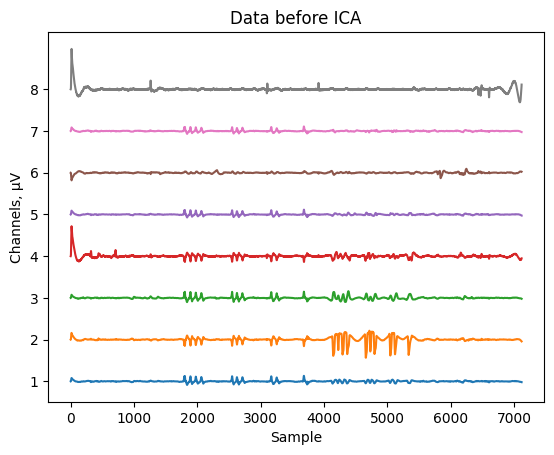

In [8]:
"""
This script visualizes multi-channel data by plotting each channel with vertical offsets to separate them,
setting y-axis ticks and labels for clarity, and adding labels and a title,
facilitating a clear view of the data before Independent Component Analysis (ICA).
"""

n_channels = data_bp_filtered.shape[1]  # number of channels
plt.plot(data_bp_filtered + range(1000, 1000*n_channels+1000, 1000))
plt.yticks(range(1000, 1000*n_channels+1000, 1000), range(1, n_channels+1))
plt.ylabel('Channels, µV')
plt.xlabel('Sample')
plt.title("Data before ICA")
plt.show()